<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [17]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [18]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [19]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [20]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [21]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [22]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
#         seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [23]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [24]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [25]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-6)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-06.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [26]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-07.
smape 65.81165977780931 %
Adjusting learning rate of group 0 to 9.0250e-07.
smape 0.6765669791064666 %
Adjusting learning rate of group 0 to 8.5737e-07.
smape 0.6461208294896676 %
Adjusting learning rate of group 0 to 8.1451e-07.
smape 0.6512832019188066 %
Adjusting learning rate of group 0 to 7.7378e-07.
smape 0.6478612427803966 %
Adjusting learning rate of group 0 to 7.3509e-07.
smape 0.6416424990383832 %
Adjusting learning rate of group 0 to 6.9834e-07.
smape 0.6305201629337402 %
Adjusting learning rate of group 0 to 6.6342e-07.
smape 0.618178618674259 %
Adjusting learning rate of group 0 to 6.3025e-07.
smape 0.6061693197078812 %
Adjusting learning rate of group 0 to 5.9874e-07.
smape 0.5925776828345924 %
Adjusting learning rate of group 0 to 5.6880e-07.
smape 0.5798082062239317 %
Adjusting learning rate of group 0 to 5.4036e-07.
smape 0.5678043254155514 %
Adjusting learning rate of group 0 to 5.1334e-07.
smape 0.5561578844889061 %
A

In [27]:
torch.manual_seed(42)

In [28]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [29]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.1555436986964196 %
SMAPE 0.0992788923322223 %
SMAPE 0.013330011109673025 %
SMAPE 0.06807836625375785 %
SMAPE 0.008258985955876597 %
SMAPE 0.014410171935594462 %
SMAPE 0.0986185188521631 %
SMAPE 0.008843425061442645 %
SMAPE 0.029955662584455922 %
SMAPE 0.046370321229915135 %
SMAPE 0.013696648031412906 %
SMAPE 0.0005033039478377077 %
SMAPE 0.0002705677979903953 %
SMAPE 0.01374247453432531 %
SMAPE 0.05571063038951252 %
SMAPE 0.022152505841461334 %
SMAPE 0.0006924664611176468 %
SMAPE 0.010169745420313347 %
SMAPE 0.003347496406263417 %
SMAPE 0.020822103308603346 %
SMAPE 0.053264766407664865 %
SMAPE 0.02953909726721804 %
SMAPE 0.10216493700863793 %
SMAPE 0.00412359970616194 %
SMAPE 0.0037305361389883274 %
SMAPE 0.13227285136235878 %
SMAPE 0.05925143141939771 %
SMAPE 0.0067243350703733995 %
SMAPE 0.028262216222628922 %
SMAPE 0.004989036640267841 %
SMAPE 0.08871780149638653 %
SMAPE 0.003687704012179438 %
SMAPE 0.12049337662756443 %
SMAPE 0.0012153454762255933 %
SMAPE 0.0205351410976390

SMAPE 0.09930610662559047 %
SMAPE 0.061265547919902026 %
SMAPE 0.10109936923254281 %
SMAPE 0.005456827031821376 %
SMAPE 0.02260140131488697 %
SMAPE 0.017238475998397007 %
SMAPE 0.000662615037526848 %
SMAPE 0.006871779917958065 %
SMAPE 0.00362121274048377 %
SMAPE 0.017610043379526985 %
SMAPE 0.0019205744819856818 %
SMAPE 0.0015055823913598942 %
SMAPE 0.02527586908770729 %
SMAPE 0.00022706537245653635 %
SMAPE 0.01955322244407398 %
SMAPE 0.003569915918703259 %
SMAPE 0.011244213716452123 %
SMAPE 0.0007251117690429965 %
SMAPE 0.013946045676505037 %
SMAPE 0.00685822667006164 %
SMAPE 0.03162560955624372 %
SMAPE 0.04851729119400261 %
SMAPE 0.029798689833341996 %
SMAPE 0.02843493159941346 %
SMAPE 0.014788884877020791 %
SMAPE 0.0017480452353879627 %
SMAPE 0.038055540240065966 %
SMAPE 0.00424350492995984 %
SMAPE 0.000848299355872939 %
SMAPE 0.0009193796128954547 %
SMAPE 0.09137477050535381 %
SMAPE 0.036443367246874914 %
SMAPE 0.017475904609241866 %
SMAPE 0.006571124979330989 %
SMAPE 0.01023661540

SMAPE 0.010802811100575127 %
SMAPE 0.0022160557637391776 %
SMAPE 0.0258040655086802 %
SMAPE 0.005916900170831241 %
SMAPE 0.0013801565888655887 %
SMAPE 0.010685216322251279 %
SMAPE 0.00790641357174593 %
SMAPE 0.07333641033619642 %
SMAPE 0.008720955665296515 %
SMAPE 0.00437121043945865 %
SMAPE 0.005838597439833393 %
SMAPE 0.009202067214403087 %
SMAPE 0.06026565561478492 %
SMAPE 0.003032182135719097 %
SMAPE 0.008999021315787559 %
SMAPE 0.013378446041699023 %
SMAPE 0.0002821292565613476 %
SMAPE 0.007518428660134191 %
SMAPE 0.0011854279214560393 %
SMAPE 0.01987291872963226 %
SMAPE 0.002642653321572652 %
SMAPE 0.00045287406263128105 %
SMAPE 0.004035245321688308 %
SMAPE 0.058337219947134145 %
SMAPE 0.010018687533758452 %
SMAPE 0.017117500097924676 %
SMAPE 0.004464030478914083 %
SMAPE 0.005879013464898719 %
SMAPE 0.03349564025666041 %
SMAPE 0.05360645186738111 %
SMAPE 0.008624896667129178 %
SMAPE 0.0027784565073858403 %
SMAPE 0.004350833406363108 %
SMAPE 0.012791767676333164 %
SMAPE 0.00858243

SMAPE 0.011918564088176709 %
SMAPE 0.0032284508000088863 %
SMAPE 0.014934334991025365 %
SMAPE 0.05917975494230632 %
SMAPE 0.018628456869009824 %
SMAPE 0.03492315694938952 %
SMAPE 0.02200731677527301 %
SMAPE 0.00216054326369175 %
SMAPE 0.020485622691666094 %
SMAPE 0.0034851261304140735 %
SMAPE 0.001364755947008689 %
SMAPE 0.007432892797396563 %
SMAPE 0.002130979864290339 %
SMAPE 0.002973928530792591 %
SMAPE 0.016695481679306567 %
SMAPE 0.0035917304206520844 %
SMAPE 0.025321132338490315 %
SMAPE 0.0012480056109041016 %
SMAPE 0.0036222534838898923 %
SMAPE 0.0019098249561864125 %
SMAPE 0.015470221435208485 %
SMAPE 0.0002808811458407945 %
SMAPE 0.00040648017107969286 %
SMAPE 0.009232475047944888 %
SMAPE 0.015664074908045222 %
SMAPE 0.02070857892821465 %
SMAPE 0.0006835808037450875 %
SMAPE 0.016293816175107168 %
SMAPE 0.04270095960055187 %
SMAPE 0.04493736168660689 %
SMAPE 0.0008382894747853697 %
SMAPE 0.010042291191240338 %
SMAPE 0.0014507354465749245 %
SMAPE 0.005252829275178783 %
SMAPE 0.0

SMAPE 0.0036785264641707727 %
SMAPE 0.016657599470875084 %
SMAPE 0.033395532778740744 %
SMAPE 0.10196675377665088 %
SMAPE 0.017928536813812457 %
SMAPE 7.71223725166692e-05 %
SMAPE 0.004635144959166837 %
SMAPE 0.017232457022203107 %
SMAPE 0.04669812065549195 %
SMAPE 0.0024836473270042347 %
SMAPE 0.11853696737671271 %
SMAPE 0.003036977744500291 %
SMAPE 0.011681785623181895 %
SMAPE 0.004353689372209146 %
SMAPE 0.0005941975048529002 %
SMAPE 0.0002602438203211932 %
SMAPE 0.042273653467418626 %
SMAPE 0.021395945370954905 %
SMAPE 0.0065138834681448534 %
SMAPE 0.0056164799708824376 %
SMAPE 0.0020442861214036157 %
SMAPE 0.006041993353591124 %
SMAPE 0.0015169708242410707 %
SMAPE 0.016020388177992118 %
SMAPE 0.02266202791605565 %
SMAPE 0.010978230809968181 %
SMAPE 0.015436050147968672 %
SMAPE 0.005097721003664901 %
SMAPE 0.007194773828018697 %
SMAPE 0.0028093959903685572 %
SMAPE 0.011240051497850345 %
SMAPE 0.0034311937382369706 %
SMAPE 0.03258044506731039 %
SMAPE 0.011690031575710691 %
SMAPE 0.0

SMAPE 0.011127663754649575 %
SMAPE 0.03157795584752421 %
SMAPE 0.017022338480934707 %
SMAPE 0.012447638801532435 %
SMAPE 0.00019389969330063647 %
SMAPE 0.002604500512660479 %
SMAPE 0.013350014492743867 %
SMAPE 0.030754395389578807 %
SMAPE 0.005957663095713883 %
SMAPE 0.0002834569116316743 %
SMAPE 0.002754180700918596 %
SMAPE 0.0039460488869238475 %
SMAPE 0.00013320115431270096 %
SMAPE 0.012068403369852376 %
SMAPE 0.004907842303509824 %
SMAPE 0.0023891358116046035 %
SMAPE 0.00849583425941347 %
SMAPE 0.005870692027301061 %
SMAPE 0.04959036374930292 %
SMAPE 0.013553630599972166 %
SMAPE 0.0027117014939221917 %
SMAPE 0.015052649347609302 %
SMAPE 0.034827373377851245 %
SMAPE 0.021954646315634818 %
SMAPE 0.0017712332245594098 %
SMAPE 0.00686236007544494 %
SMAPE 0.013273319272670394 %
SMAPE 0.02834162242220373 %
SMAPE 0.0012319544052701303 %
SMAPE 0.0019164133703384323 %
SMAPE 0.017465145912410662 %
SMAPE 0.029145223807290677 %
SMAPE 0.03180337732760563 %
SMAPE 0.00619783999420065 %
SMAPE 0.00

SMAPE 0.0037980875154914884 %
SMAPE 0.06715692189754918 %
SMAPE 0.0004356704654639998 %
SMAPE 0.001851358103706957 %
SMAPE 0.010861864671539934 %
SMAPE 0.0007006987499664774 %
SMAPE 0.03611820027367685 %
SMAPE 0.022305432422399463 %
SMAPE 0.01016603675483907 %
SMAPE 0.02070940891206874 %
SMAPE 0.05212976664188318 %
SMAPE 0.01039109770391633 %
SMAPE 0.012749081442734678 %
SMAPE 0.003989955330354178 %
SMAPE 0.010596783488523442 %
SMAPE 0.08097805385477841 %
SMAPE 0.006978820270717279 %
SMAPE 0.0051656004322921945 %
SMAPE 0.006597373378269822 %
SMAPE 0.007118779312378364 %
SMAPE 0.06383993370400276 %
SMAPE 0.025728530722403775 %
SMAPE 0.016435092492827152 %
SMAPE 0.03122473703479045 %
SMAPE 0.0032335141499686415 %
SMAPE 0.018668209842189754 %
SMAPE 0.001391655721171503 %
SMAPE 0.011378868739512882 %
SMAPE 0.020935950959255933 %
SMAPE 0.0005201820755473818 %
SMAPE 0.00024931466775512945 %
SMAPE 0.00036443249663875577 %
SMAPE 0.006486697289517451 %
SMAPE 0.04247968558956927 %
SMAPE 0.039475

SMAPE 0.036611922638257965 %
SMAPE 0.010587280957849998 %
SMAPE 0.0027613583824575016 %
SMAPE 0.029028089611131236 %
SMAPE 0.022410635415099023 %
SMAPE 0.0005521330231346155 %
SMAPE 0.0009607661626702679 %
SMAPE 0.00869515073119942 %
SMAPE 0.0012534216814685806 %
SMAPE 0.0007362588911519197 %
SMAPE 0.016298542670995175 %
SMAPE 0.07788814636296593 %
SMAPE 0.0925347984302789 %
SMAPE 0.0027083916355650217 %
SMAPE 0.01470738338730371 %
SMAPE 0.009034221801954345 %
SMAPE 0.003448012631700692 %
SMAPE 0.00026785720311295336 %
SMAPE 0.03547824530187427 %
SMAPE 0.01175296978991014 %
SMAPE 0.016960897504596062 %
SMAPE 0.014694091239988438 %
SMAPE 0.014916101779760993 %
SMAPE 0.00057451574880929 %
SMAPE 0.0023318903777607147 %
SMAPE 0.021099774257208992 %
SMAPE 0.006101030516248329 %
SMAPE 0.021977063478203718 %
SMAPE 0.0047607794195840825 %
SMAPE 0.006267346663804574 %
SMAPE 0.003922231301515922 %
SMAPE 0.008510776393919173 %
SMAPE 0.0021724561362646 %
SMAPE 0.04195889915990847 %
SMAPE 0.0313446

SMAPE 0.042692728213296505 %
SMAPE 0.0017964381481476721 %
SMAPE 0.00015427696633452115 %
SMAPE 0.04702150962839369 %
SMAPE 0.11301471781916916 %
SMAPE 0.004395402411674354 %
SMAPE 0.0782155989727471 %
SMAPE 0.0666217384277843 %
SMAPE 0.025726550515514646 %
SMAPE 0.03304885425791326 %
SMAPE 0.016738982637605204 %
SMAPE 0.061669878734392114 %
SMAPE 0.0022694074290825483 %
SMAPE 0.009660767622897026 %
SMAPE 0.04458571888972074 %
SMAPE 0.04338652287697187 %
SMAPE 0.0017111820217792229 %
SMAPE 0.050772321075783104 %
SMAPE 0.00045730275353150773 %
SMAPE 0.041094563924161776 %
SMAPE 0.015368792567343803 %
SMAPE 0.0013482739572765468 %
SMAPE 0.0027732421204191837 %
SMAPE 0.01608958519025805 %
SMAPE 0.0028327752446841714 %
SMAPE 0.006169033999633201 %
SMAPE 0.05535374535247683 %
SMAPE 0.01835167037904739 %
SMAPE 0.07921744449413382 %
SMAPE 0.014111479815575478 %
SMAPE 0.007738399021619102 %
SMAPE 0.041952656752982875 %
SMAPE 0.09895572508685291 %
SMAPE 0.009063773768929195 %
SMAPE 0.0490250236

SMAPE 0.054203783394768834 %
SMAPE 0.010031216473237237 %
SMAPE 0.01172627408143967 %
SMAPE 0.004687161041715626 %
SMAPE 0.0022532452512109558 %
SMAPE 0.03955701040422355 %
SMAPE 0.03604174968609186 %
SMAPE 0.0300556831589347 %
SMAPE 0.0132945628220682 %
SMAPE 0.022458665368688457 %
SMAPE 0.06282115932845045 %
SMAPE 0.017789113251239996 %
SMAPE 0.0743198549898807 %
SMAPE 0.006050941601131399 %
SMAPE 0.08974773896625265 %
SMAPE 0.0009944054189645612 %
SMAPE 0.03414163402521808 %
SMAPE 0.14676049235276878 %
SMAPE 0.0022595486610157423 %
SMAPE 0.004460242883418175 %
SMAPE 0.024055416256032913 %
SMAPE 0.004550969946762962 %
SMAPE 0.0032509705242773634 %
SMAPE 0.07256374842836522 %
SMAPE 0.036045446717992036 %
SMAPE 0.016094102455987525 %
SMAPE 0.007442900376460671 %
SMAPE 0.0005487041596410336 %
SMAPE 0.00151017082124838 %
SMAPE 0.012331116628089944 %
SMAPE 0.014216577033181464 %
SMAPE 0.021163289521183515 %
SMAPE 0.12060403742361814 %
SMAPE 0.007495985062213605 %
SMAPE 0.00467578682230396

SMAPE 17.90719845890999 %
SMAPE 25.811993032693863 %
SMAPE 9.57981277257204 %
SMAPE 8.005785204470158 %
SMAPE 6.5945110991597184 %
SMAPE 1.5200742417946458 %
SMAPE 0.7391391177661717 %
SMAPE 0.8197129918262362 %
SMAPE 1.563003284856677 %
SMAPE 1.3399609820917249 %
SMAPE 1.2296379832550883 %
SMAPE 0.9567316016182303 %
SMAPE 0.01119940529173391 %
SMAPE 0.12157429818762466 %
SMAPE 0.17027503391727805 %
SMAPE 0.1341824940755032 %
SMAPE 0.1289945927564986 %
SMAPE 0.3324338709935546 %
SMAPE 0.003925418858088392 %
SMAPE 0.7297228923998773 %
SMAPE 1.0143875060603023 %
SMAPE 0.8822685228660704 %
SMAPE 0.7898028818890451 %
SMAPE 0.3936828889418393 %
SMAPE 0.15368451864924282 %
SMAPE 0.29844988347031176 %
SMAPE 0.14566482277587056 %
SMAPE 0.20670367497950792 %
SMAPE 0.018323388500448345 %
SMAPE 0.377913503209129 %
SMAPE 0.427179362392053 %
SMAPE 0.20994290930684656 %
SMAPE 0.03691984775196033 %
SMAPE 0.18150475376751274 %
SMAPE 0.02604765623647154 %
SMAPE 0.27700759121216834 %
SMAPE 0.34968646522

SMAPE 0.03694659448723314 %
SMAPE 0.21484563604462892 %
SMAPE 0.356099805328995 %
SMAPE 0.02075741480751958 %
SMAPE 0.5452850246801972 %
SMAPE 0.00714436126554574 %
SMAPE 0.06271677212498616 %
SMAPE 0.32723009772598743 %
SMAPE 0.2270373838255182 %
SMAPE 0.14353144611231983 %
SMAPE 0.28850284218788147 %
SMAPE 0.4008458782918751 %
SMAPE 0.6520224846899509 %
SMAPE 1.0022686636075377 %
SMAPE 0.58173265773803 %
SMAPE 0.16544803022406995 %
SMAPE 0.30731310206465423 %
SMAPE 0.1868328555719927 %
SMAPE 0.7205148017965257 %
SMAPE 0.7774720983579755 %
SMAPE 0.8306511966511607 %
SMAPE 0.3159349770285189 %
SMAPE 0.48339273547753686 %
SMAPE 0.6099632494151592 %
SMAPE 0.3669380829669535 %
SMAPE 0.17853880254551768 %
SMAPE 0.18990126997232437 %
SMAPE 0.0012581346912696745 %
SMAPE 0.18086386297363788 %
SMAPE 0.9263379285112023 %
SMAPE 0.9803255908191205 %
SMAPE 0.35063584917224944 %
SMAPE 0.07460341326077469 %
SMAPE 0.16256899305153638 %
SMAPE 0.306027221493423 %
SMAPE 0.35234488686546683 %
SMAPE 0.323

SMAPE 0.8779434962198138 %
SMAPE 0.7922987234778702 %
SMAPE 0.05355807559681124 %
SMAPE 0.015326410865782236 %
SMAPE 0.2611545172985643 %
SMAPE 0.216058709542267 %
SMAPE 0.10201798763591796 %
SMAPE 0.1479059875709936 %
SMAPE 0.7479629996232688 %
SMAPE 0.6984648606739938 %
SMAPE 0.39105736301280564 %
SMAPE 0.11224051221506672 %
SMAPE 0.2803140126634389 %
SMAPE 0.10752442933153361 %
SMAPE 0.20764886983670297 %
SMAPE 0.0042857101776476725 %
SMAPE 0.2787328101694584 %
SMAPE 0.16627586272079498 %
SMAPE 0.5700889071449637 %
SMAPE 0.47391734598204494 %
SMAPE 0.004663599159897558 %
SMAPE 0.6638243296183646 %
SMAPE 0.3365293105598539 %
SMAPE 0.2277475751470774 %
SMAPE 0.02530985656892426 %
SMAPE 0.22926294000353664 %
SMAPE 0.14708095917012542 %
SMAPE 0.30142389377579093 %
SMAPE 0.03391735121441286 %
SMAPE 0.12166524794884027 %
SMAPE 0.5334960911422968 %
SMAPE 1.0193973574787378 %
SMAPE 1.1673531336709857 %
SMAPE 0.7430044529028237 %
SMAPE 0.018030578304887968 %
SMAPE 0.3061518887989223 %
SMAPE 

SMAPE 0.16111478803213686 %
SMAPE 0.36090946616604924 %
SMAPE 0.21546153596136722 %
SMAPE 0.1744510653661564 %
SMAPE 0.06259788078023121 %
SMAPE 0.7951143570244312 %
SMAPE 0.6022450868040323 %
SMAPE 0.49060346791520715 %
SMAPE 0.2990397526882589 %
SMAPE 0.6920318752527237 %
SMAPE 0.42858771025203163 %
SMAPE 0.0011334545561183518 %
SMAPE 0.13829185056965798 %
SMAPE 0.36115658935159445 %
SMAPE 0.10804579721298069 %
SMAPE 0.08587220951449126 %
SMAPE 0.010191910861635733 %
SMAPE 0.03234811847414676 %
SMAPE 0.1777791860513389 %
SMAPE 0.5846455311402678 %
SMAPE 0.3399516132194549 %
SMAPE 0.0007445649550774647 %
SMAPE 0.2479986255057156 %
SMAPE 0.15431129361968488 %
SMAPE 0.010176140758488827 %
SMAPE 0.15696768031921238 %
SMAPE 0.5248466613702476 %
SMAPE 0.2283284246223047 %
SMAPE 1.186103070154786 %
SMAPE 1.0936236632987857 %
SMAPE 0.8730173986405134 %
SMAPE 0.5820028693415225 %
SMAPE 0.676538051571697 %
SMAPE 0.02568612171762652 %
SMAPE 0.05311799264745787 %
SMAPE 0.3109454324003309 %
SMAPE

SMAPE 0.2747681972105056 %
SMAPE 0.5259763207286596 %
SMAPE 0.10996111511485651 %
SMAPE 0.004112748248445541 %
SMAPE 0.00872963489318579 %
SMAPE 0.8940522167831659 %
SMAPE 0.7476650583557785 %
SMAPE 0.2957313971128315 %
SMAPE 0.38286204100586474 %
SMAPE 0.8650989094749093 %
SMAPE 1.4399421093985438 %
SMAPE 1.7837590631097557 %
SMAPE 1.3867945587262511 %
SMAPE 0.6819438580423594 %
SMAPE 0.5508349663577974 %
SMAPE 0.6910909619182348 %
SMAPE 0.15705981978680938 %
SMAPE 0.44808051176369196 %
SMAPE 0.3326710171531886 %
SMAPE 0.0491095500983647 %
SMAPE 0.5722435773350298 %
SMAPE 0.14067268220242113 %
SMAPE 0.2616882319562137 %
SMAPE 0.19455232610926032 %
SMAPE 0.4181950683705509 %
SMAPE 0.013253540785910902 %
SMAPE 0.34719015401788056 %
SMAPE 0.24815660598687828 %
SMAPE 0.6391865801997483 %
SMAPE 0.5664231823757291 %
SMAPE 0.4123520287685096 %
SMAPE 0.49401504360139364 %
SMAPE 0.09152942651417106 %
SMAPE 0.6178037845529616 %
SMAPE 0.4493266884237528 %
SMAPE 0.009077102549525762 %
SMAPE 0.559

SMAPE 9.57048261910677 %
SMAPE 6.475401401519775 %
SMAPE 5.84266372025013 %
SMAPE 7.058730363845825 %
SMAPE 9.676361590623856 %
SMAPE 10.930634468793869 %
SMAPE 8.793791510164738 %
SMAPE 6.313929997384548 %
SMAPE 5.920407973229885 %
SMAPE 3.602081775665283 %
SMAPE 0.32916070451028645 %
SMAPE 1.262977153994143 %
SMAPE 2.342563746497035 %
SMAPE 2.295410780236125 %
SMAPE 2.041117634624243 %
SMAPE 1.893411546945572 %
SMAPE 1.4321584403514862 %
SMAPE 1.165265447460115 %
SMAPE 1.1223476715385914 %
SMAPE 1.084783636033535 %
SMAPE 0.9261486781761051 %
SMAPE 1.0330333169549704 %
SMAPE 1.0449658511206508 %
SMAPE 0.9969000769779086 %
SMAPE 0.9598839143291117 %
SMAPE 0.8578671431168914 %
SMAPE 0.6779613490216434 %
SMAPE 0.6514295386150479 %
SMAPE 0.5106913191266358 %
SMAPE 0.2972690612077713 %
SMAPE 0.09785374539205804 %
SMAPE 0.5156256002373993 %
SMAPE 2.0320290997624397 %
SMAPE 0.48060660203918815 %
SMAPE 0.11980914807645604 %
SMAPE 0.19919882097747177 %
SMAPE 0.5138318622484803 %
SMAPE 0.448612

SMAPE 0.5558232511393726 %
SMAPE 0.8367156274616718 %
SMAPE 0.4423930160701275 %
SMAPE 0.19133307971060276 %
SMAPE 0.8266024990007281 %
SMAPE 1.2734252596274018 %
SMAPE 1.5745956758037207 %
SMAPE 1.4461261257529259 %
SMAPE 1.6186433024704456 %
SMAPE 1.0119530661031604 %
SMAPE 0.6927118860185146 %
SMAPE 0.11624120560009031 %
SMAPE 1.7608952652662995 %
SMAPE 0.7762446771375835 %
SMAPE 0.33292201394215226 %
SMAPE 0.16872668080031872 %
SMAPE 0.0711074108548928 %
SMAPE 0.9368155561387539 %
SMAPE 1.2820767341181636 %
SMAPE 1.1770491730421782 %
SMAPE 0.09094717167317867 %
SMAPE 1.3161094235256314 %
SMAPE 1.4640680672600865 %
SMAPE 0.966253730468452 %
SMAPE 0.21637091494631022 %
SMAPE 1.8182952795177696 %
SMAPE 1.0055629843845963 %
SMAPE 1.0547985285520554 %
SMAPE 0.772191452793777 %
SMAPE 1.3224191833287477 %
SMAPE 0.07613865548046306 %
SMAPE 0.32034477731212974 %
SMAPE 0.17228421766776592 %
SMAPE 0.717288913205266 %
SMAPE 0.0004977468107654204 %
SMAPE 1.0212148474529386 %
SMAPE 0.70452845375

SMAPE 0.9475346542894841 %
SMAPE 1.236387288197875 %
SMAPE 0.8464437518268824 %
SMAPE 0.38956341659650207 %
SMAPE 0.5134050394408405 %
SMAPE 0.7912606010213494 %
SMAPE 1.0343518368899822 %
SMAPE 0.5523114525713027 %
SMAPE 0.18276693811640143 %
SMAPE 0.1950814101146534 %
SMAPE 0.39278182410635054 %
SMAPE 0.5204598698765039 %
SMAPE 0.299181560985744 %
SMAPE 0.05879053199896589 %
SMAPE 0.027762078041831728 %
SMAPE 0.18904967745766044 %
SMAPE 0.42392825940623885 %
SMAPE 0.47728751599788666 %
SMAPE 0.31961399130523205 %
SMAPE 0.19285138335544616 %
SMAPE 0.024370733067712536 %
SMAPE 0.36714998609386384 %
SMAPE 0.3350430883001536 %
SMAPE 0.11815802892670035 %
SMAPE 0.0014680305871053179 %
SMAPE 0.21234592678956687 %
SMAPE 0.5185377513989806 %
SMAPE 0.4299978422932327 %
SMAPE 0.6179884253069758 %
SMAPE 0.6672069914638996 %
SMAPE 0.1966335652396083 %
SMAPE 0.0005840268801620141 %
SMAPE 0.28965740953572094 %
SMAPE 0.7097926270216703 %
SMAPE 0.8523405790328978 %
SMAPE 0.859258821234107 %
SMAPE 0.

SMAPE 0.7143087866716087 %
SMAPE 0.44118111301213503 %
SMAPE 0.3202302046120167 %
SMAPE 0.6344542051665485 %
SMAPE 0.39615280507132417 %
SMAPE 0.3147568835411221 %
SMAPE 0.015992661692024512 %
SMAPE 0.467829889152199 %
SMAPE 0.5818317234516144 %
SMAPE 0.21457193105015904 %
SMAPE 0.05215058918111026 %
SMAPE 0.19138314167503268 %
SMAPE 0.36662590433843434 %
SMAPE 0.1668684333562851 %
SMAPE 0.3203525519929826 %
SMAPE 0.39358417293988174 %
SMAPE 0.21294979681260887 %
SMAPE 0.3162420983426273 %
SMAPE 0.46774940378963953 %
SMAPE 0.6968929935246706 %
SMAPE 0.67044174997136 %
SMAPE 1.0573602672666311 %
SMAPE 1.3550316281616688 %
SMAPE 1.1394997276365757 %
SMAPE 0.639916819985956 %
SMAPE 0.7464321446605027 %
SMAPE 0.7701471815817058 %
SMAPE 0.4729359447956085 %
SMAPE 0.13214094302384183 %
SMAPE 0.016624406540358905 %
SMAPE 0.034121633533118256 %
SMAPE 0.21823997923638672 %
SMAPE 0.9266224047169089 %
SMAPE 0.9238415658473967 %
SMAPE 0.3486487178597599 %
SMAPE 0.11193063482642174 %
SMAPE 0.422013

SMAPE 0.6885878453031182 %
SMAPE 0.6725223292596638 %
SMAPE 0.3751775457058102 %
SMAPE 0.22523724916391075 %
SMAPE 0.043435326479084324 %
SMAPE 0.22434476704802364 %
SMAPE 0.04435628059582086 %
SMAPE 0.025958274481013177 %
SMAPE 0.1165471392450854 %
SMAPE 0.1447002311469987 %
SMAPE 0.012009864148993188 %
SMAPE 0.4581564776599407 %
SMAPE 0.556569395121187 %
SMAPE 0.01062616553726059 %
SMAPE 0.3650424925144762 %
SMAPE 0.2678837913554162 %
SMAPE 0.106907831330318 %
SMAPE 0.13988540729042143 %
SMAPE 0.011766012003462833 %
SMAPE 0.1061041309731081 %
SMAPE 0.07079780491767451 %
SMAPE 0.19470218662172556 %
SMAPE 0.5225938488729298 %
SMAPE 0.2068036572309211 %
SMAPE 0.5742569202557206 %
SMAPE 0.5720973392017186 %
SMAPE 0.06489833279920276 %
SMAPE 0.5385827762074769 %
SMAPE 0.8511813953518867 %
SMAPE 0.7772469040937722 %
SMAPE 0.23029386380221695 %
SMAPE 0.31671153963543475 %
SMAPE 0.6747846947982907 %
SMAPE 0.23137822258286178 %
SMAPE 0.47179414890706534 %
SMAPE 0.8298711106181144 %
SMAPE 0.58

SMAPE 0.37345608859322965 %
SMAPE 0.27087359433062375 %
SMAPE 0.05384169355966151 %
SMAPE 0.0811228898819536 %
SMAPE 0.010804570240509292 %
SMAPE 0.11864464881364256 %
SMAPE 0.020309190568355007 %
SMAPE 0.2580826331395656 %
SMAPE 0.18446430785115808 %
SMAPE 0.12541818735189736 %
SMAPE 0.1999904967378825 %
SMAPE 0.15414269245229661 %
SMAPE 0.33123462717048824 %
SMAPE 0.03999485778899725 %
SMAPE 0.3716977166477591 %
SMAPE 0.10938577313208953 %
SMAPE 0.472515398170799 %
SMAPE 0.3883339730091393 %
SMAPE 0.43304680241271853 %
SMAPE 0.32069820957258344 %
SMAPE 0.2190580159658566 %
SMAPE 0.0015217286899940063 %
SMAPE 0.030540133329623135 %
SMAPE 0.34811492334119976 %
SMAPE 0.3161507435142994 %
SMAPE 0.12809289514552802 %
SMAPE 0.143372560152784 %
SMAPE 0.07736406609183177 %
SMAPE 0.2059262249385938 %
SMAPE 0.09077098104171455 %
SMAPE 0.049838787715998485 %
SMAPE 0.15121147583704442 %
SMAPE 0.15156276617199183 %
SMAPE 0.17102796817198396 %
SMAPE 0.0048555884712015995 %
SMAPE 0.1457223767647519

SMAPE 0.0021928196342742012 %
SMAPE 0.010160734701855745 %
SMAPE 0.12922833737684414 %
SMAPE 0.26161273778416216 %
SMAPE 0.07280977087793872 %
SMAPE 0.29428148712031543 %
SMAPE 0.021782402715018634 %
SMAPE 0.11393734166631475 %
SMAPE 0.14280852465890348 %
SMAPE 0.16507765394635499 %
SMAPE 0.0008072540020052088 %
SMAPE 0.03440083707505437 %
SMAPE 0.1030384263722226 %
SMAPE 0.3400040923152119 %
SMAPE 0.0010331438177786367 %
SMAPE 0.06981879458180629 %
SMAPE 0.1992700077826157 %
SMAPE 0.16334159183315933 %
SMAPE 0.004079286064282428 %
SMAPE 0.27173631777986884 %
SMAPE 0.2701447063591331 %
SMAPE 0.00856348252543171 %
SMAPE 0.10152189648943023 %
SMAPE 0.05589482397772372 %
SMAPE 0.1492174242157489 %
SMAPE 0.12058355618501082 %
SMAPE 0.26081279828213155 %
SMAPE 0.07613199506886303 %
SMAPE 0.197553159436211 %
SMAPE 0.03991256422591505 %
SMAPE 0.031589245663781185 %
SMAPE 0.005601597146267068 %
SMAPE 0.13857733935583383 %
SMAPE 0.06808078283211216 %
SMAPE 0.0020548614533879572 %
SMAPE 0.229131

SMAPE 0.18242991215083748 %
SMAPE 0.13018389471108094 %
SMAPE 0.0012486772816941993 %
SMAPE 0.08901718381093815 %
SMAPE 0.03824230482982216 %
SMAPE 0.05459647030511405 %
SMAPE 0.09500486036995426 %
SMAPE 0.041540420947967505 %
SMAPE 0.1099403309635818 %
SMAPE 0.004597724822524185 %
SMAPE 0.19506390101742 %
SMAPE 0.053643476974684745 %
SMAPE 0.28305801656097174 %
SMAPE 0.05077412719401764 %
SMAPE 0.04089784508732919 %
SMAPE 0.017399300455096522 %
SMAPE 0.06432367255911231 %
SMAPE 0.0007651018776186902 %
SMAPE 0.1259865587344393 %
SMAPE 0.3115839487873018 %
SMAPE 0.1581256428034976 %
SMAPE 0.03148974926853043 %
SMAPE 0.15720816142857075 %
SMAPE 0.08671756915282458 %
SMAPE 0.01571293805983487 %
SMAPE 0.18623894406482577 %
SMAPE 0.08230367169016972 %
SMAPE 0.002742779858834865 %
SMAPE 0.004276504858751196 %
SMAPE 0.07315287631354295 %
SMAPE 0.0974572806735523 %
SMAPE 0.002218058222595687 %
SMAPE 0.017024718852724163 %
SMAPE 0.07260494897491299 %
SMAPE 0.1182233106228523 %
SMAPE 0.075905360

SMAPE 0.06945116654969752 %
SMAPE 0.08777207994717173 %
SMAPE 0.07733320773695596 %
SMAPE 0.0007131295232625234 %
SMAPE 0.2038784257601947 %
SMAPE 0.19590718753170222 %
SMAPE 0.05493329672026448 %
SMAPE 0.10757685150019825 %
SMAPE 0.08420746581396088 %
SMAPE 0.033597345222915465 %
SMAPE 0.09438569191843271 %
SMAPE 0.12769489322090521 %
SMAPE 0.01707172505774679 %
SMAPE 0.12101488857297227 %
SMAPE 0.026054967245556778 %
SMAPE 0.04178519091146882 %
SMAPE 0.19941033551003784 %
SMAPE 0.032614251839504504 %
SMAPE 0.15328858071006835 %
SMAPE 0.12258224346442148 %
SMAPE 0.003664432447834543 %
SMAPE 0.2351398360915482 %
SMAPE 0.08658323003328405 %
SMAPE 0.12168806174304336 %
SMAPE 0.20796084753237665 %
SMAPE 0.15933419135399163 %
SMAPE 0.10216072102775797 %
SMAPE 0.20242017845157534 %
SMAPE 0.07798041918431409 %
SMAPE 0.0939287151559256 %
SMAPE 0.009530999692714204 %
SMAPE 0.0016703201373360346 %
SMAPE 0.31165074557065964 %
SMAPE 0.24819850828498602 %
SMAPE 0.027471034166808295 %
SMAPE 0.01805

SMAPE 0.0009178825968660932 %
SMAPE 0.0008846743458761352 %
SMAPE 0.03797891181295654 %
SMAPE 0.08338621607981622 %
SMAPE 0.0008192943297231637 %
SMAPE 0.005297278228169944 %
SMAPE 0.018301630331393426 %
SMAPE 0.09473201190121472 %
SMAPE 0.1782844173721969 %
SMAPE 0.015409277140634002 %
SMAPE 0.010968128777960828 %
SMAPE 0.08497622344293632 %
SMAPE 0.0013617888052479543 %
SMAPE 0.12865057215094566 %
SMAPE 0.0720840189314913 %
SMAPE 0.11313438735669479 %
SMAPE 0.007648098055668129 %
SMAPE 0.2642238561529666 %
SMAPE 0.00457243628004278 %
SMAPE 0.17144536308478564 %
SMAPE 0.09024444228271022 %
SMAPE 0.11069504951592535 %
SMAPE 0.024794312140443253 %
SMAPE 0.08576624406850897 %
SMAPE 0.07287469127913937 %
SMAPE 0.11442083190195261 %
SMAPE 0.0006513729460664308 %
SMAPE 0.0010588156316231334 %
SMAPE 0.22053267259616402 %
SMAPE 0.100961668882519 %
SMAPE 0.0274399128661571 %
SMAPE 0.057258948625531055 %
SMAPE 0.006784621142223557 %
SMAPE 0.010821739649088613 %
SMAPE 0.027115354678159065 %
SMAP

SMAPE 0.00013398643349660233 %
SMAPE 0.07549445156473666 %
SMAPE 0.015265722408940974 %
SMAPE 0.09159817808540538 %
SMAPE 0.17046581383328885 %
SMAPE 0.016745024994690993 %
SMAPE 0.0007999887233296475 %
SMAPE 0.03336664104540432 %
SMAPE 0.005391866213379615 %
SMAPE 0.003990024642341439 %
SMAPE 0.01742483532194683 %
SMAPE 0.012114980541667819 %
SMAPE 0.27289313450455666 %
SMAPE 0.002300486616391595 %
SMAPE 0.00041119962897084866 %
SMAPE 0.003034731847748162 %
SMAPE 0.045476864113879856 %
SMAPE 0.0040201912565862585 %
SMAPE 0.07492646964965388 %
SMAPE 0.003491972018537126 %
SMAPE 0.002131836928178643 %
SMAPE 0.0009247637984302061 %
SMAPE 0.07776300798286684 %
SMAPE 0.038355413030330965 %
SMAPE 0.00032724739398304337 %
SMAPE 0.09300551825435832 %
SMAPE 0.011913472568210182 %
SMAPE 0.0006653078316531946 %
SMAPE 0.04583289386209799 %
SMAPE 0.021262367955898753 %
SMAPE 0.03747809826234061 %
SMAPE 0.0828331428929232 %
SMAPE 0.05885686866531614 %
SMAPE 0.06554784087347798 %
SMAPE 0.00641095133

SMAPE 0.0004867896951736838 %
SMAPE 0.006094412713281372 %
SMAPE 0.00047384853556309276 %
SMAPE 0.00988831367220655 %
SMAPE 0.01951677241244454 %
SMAPE 0.004731898444816807 %
SMAPE 0.006823502885083599 %
SMAPE 0.011047743118069775 %
SMAPE 0.02212517609472542 %
SMAPE 0.05686240732029547 %
SMAPE 0.0006144758167465625 %
SMAPE 0.002270470902359989 %
SMAPE 0.010198486030333243 %
SMAPE 0.04535136253980454 %
SMAPE 0.000434529670613415 %
SMAPE 0.004297338149626739 %
SMAPE 0.014288983352855666 %
SMAPE 0.03040830892427948 %
SMAPE 0.2213209265610203 %
SMAPE 0.12790539057459682 %
SMAPE 0.007262763642359005 %
SMAPE 0.13936843257397413 %
SMAPE 0.09429489227477461 %
SMAPE 0.012123041990861338 %
SMAPE 0.025838477477236665 %
SMAPE 0.012722211575095344 %
SMAPE 0.016407575757938275 %
SMAPE 0.07976486178813502 %
SMAPE 0.004321496257219337 %
SMAPE 0.04117548519934644 %
SMAPE 0.009534370757393162 %
SMAPE 0.04291917715636373 %
SMAPE 0.0956512875854969 %
SMAPE 0.05383706220891327 %
SMAPE 0.0023722685766642826

SMAPE 0.014493608399234859 %
SMAPE 0.00862558467326835 %
SMAPE 0.006396752122412863 %
SMAPE 0.08420708138146438 %
SMAPE 0.03254729316859084 %
SMAPE 0.002919280523038026 %
SMAPE 0.04484169178613229 %
SMAPE 0.05499685922404752 %
SMAPE 0.0046685404376347606 %
SMAPE 0.005782944926011169 %
SMAPE 0.034269556029585146 %
SMAPE 0.03320218474812009 %
SMAPE 0.06387848044687416 %
SMAPE 0.007287927118028392 %
SMAPE 0.011982971322083813 %
SMAPE 0.004841791222474967 %
SMAPE 0.012003832634434275 %
SMAPE 0.009939292254387055 %
SMAPE 0.003045405321927319 %
SMAPE 0.006071200374918817 %
SMAPE 0.025152451818300392 %
SMAPE 0.04957133151765448 %
SMAPE 0.0007366128512131809 %
SMAPE 0.0006750033497411323 %
SMAPE 0.007652255446409129 %
SMAPE 0.007622004713681463 %
SMAPE 0.0020184618927316933 %
SMAPE 0.017146461358549914 %
SMAPE 0.002921320443931563 %
SMAPE 0.0021783380656899 %
SMAPE 0.03167431966903678 %
SMAPE 0.040483791241513245 %
SMAPE 0.0006404722702200161 %
SMAPE 0.007849518737430117 %
SMAPE 0.000616361779

SMAPE 0.0032548153767990584 %
SMAPE 0.007533701512556944 %
SMAPE 0.0022028889497107684 %
SMAPE 0.0136316182074836 %
SMAPE 0.0010445520245383477 %
SMAPE 0.03745567206237865 %
SMAPE 0.001591353903314996 %
SMAPE 0.018335916844620215 %
SMAPE 0.0011737742425381725 %
SMAPE 0.04108187239671679 %
SMAPE 0.04795906401704997 %
SMAPE 0.0007441375265244687 %
SMAPE 0.000182638564666604 %
SMAPE 0.0055630594913225195 %
SMAPE 0.023824385897114553 %
SMAPE 0.02375455345458022 %
SMAPE 0.004547213296532959 %
SMAPE 0.0060666337991506225 %
SMAPE 0.0006316353432822552 %
SMAPE 0.029781083228499487 %
SMAPE 0.044265947268286254 %
SMAPE 0.0018470455102885808 %
SMAPE 0.006760429910997345 %
SMAPE 0.001847846752930593 %
SMAPE 0.02225995806895753 %
SMAPE 0.03348744038066798 %
SMAPE 0.001403157645512465 %
SMAPE 0.005906723904629985 %
SMAPE 0.027253062183945076 %
SMAPE 0.01674563116283423 %
SMAPE 0.01764269962995968 %
SMAPE 0.06339991773711517 %
SMAPE 0.006034075438364539 %
SMAPE 0.016951567104484866 %
SMAPE 0.10363892

SMAPE 0.04973902314668521 %
SMAPE 0.005186861801405485 %
SMAPE 0.07045585548621602 %
SMAPE 0.004832171668368801 %
SMAPE 0.014770670519908435 %
SMAPE 0.031379935889845 %
SMAPE 0.015393705623147015 %
SMAPE 0.0011911852271850876 %
SMAPE 0.007903220055368365 %
SMAPE 0.022628881446848936 %
SMAPE 0.046045663810218684 %
SMAPE 0.014229243545244685 %
SMAPE 0.01083878630606705 %
SMAPE 0.007490605868269995 %
SMAPE 0.01387291624394038 %
SMAPE 0.00023206201279890593 %
SMAPE 0.0005565420651123532 %
SMAPE 0.004516766455964216 %
SMAPE 0.02580287931004932 %
SMAPE 0.04113438164222316 %
SMAPE 0.00046880553676942327 %
SMAPE 0.01054737507632808 %
SMAPE 0.01143081092757825 %
SMAPE 0.0016826455246317096 %
SMAPE 0.03971017759886308 %
SMAPE 0.004145273090387036 %
SMAPE 0.03521770556392312 %
SMAPE 0.0011773604504128343 %
SMAPE 0.019287917785788977 %
SMAPE 0.0069757782846480145 %
SMAPE 0.03284627579023436 %
SMAPE 0.005698503681884404 %
SMAPE 0.018127484456613274 %
SMAPE 0.007259074438763945 %
SMAPE 0.02300096865

SMAPE 0.0051340505515327095 %
SMAPE 0.01646911559947739 %
SMAPE 0.02252546348336182 %
SMAPE 0.003157778217854457 %
SMAPE 0.008226082454150685 %
SMAPE 0.02422096739741164 %
SMAPE 0.08219860380631872 %
SMAPE 0.011638271345390194 %
SMAPE 0.011883792970600382 %
SMAPE 0.004839323188690514 %
SMAPE 0.0008244778459740587 %
SMAPE 0.014022857184563975 %
SMAPE 0.03403178788494188 %
SMAPE 0.012666009531102416 %
SMAPE 0.0036734326605767365 %
SMAPE 0.001677314603995228 %
SMAPE 0.008085139609249836 %
SMAPE 0.01937790584730692 %
SMAPE 0.02555063828680204 %
SMAPE 0.0013074432686863702 %
SMAPE 0.0012103560296026217 %
SMAPE 0.005969589862651503 %
SMAPE 0.0009318546054402077 %
SMAPE 0.0036330049841382106 %
SMAPE 0.0004496165303606858 %
SMAPE 0.0006642144196149502 %
SMAPE 0.016251919971630002 %
SMAPE 0.0033430807224021915 %
SMAPE 0.014236172734001682 %
SMAPE 0.014043423135888135 %
SMAPE 0.02737617298674877 %
SMAPE 0.0015937513385892998 %
SMAPE 0.009005093143457543 %
SMAPE 0.0597450004570419 %
SMAPE 0.00348

SMAPE 0.00126956987912763 %
SMAPE 0.0008070368502899328 %
SMAPE 0.0009807298964119582 %
SMAPE 0.018397466611332902 %
SMAPE 0.06100967555539682 %
SMAPE 0.0023160579882812726 %
SMAPE 0.0024940611689387993 %
SMAPE 0.01921653203177698 %
SMAPE 0.018524943776071723 %
SMAPE 0.0005246161380512149 %
SMAPE 0.0008734844373208261 %
SMAPE 0.011997789653008795 %
SMAPE 0.0033215612974970554 %
SMAPE 0.003068471021308028 %
SMAPE 0.017459719067971946 %
SMAPE 0.0014308675647853875 %
SMAPE 0.028505637401444517 %
SMAPE 0.043963097075902624 %
SMAPE 0.03821751506200144 %
SMAPE 0.0006277306003283911 %
SMAPE 0.003134158305670098 %
SMAPE 0.011348783260473283 %
SMAPE 0.00010617156640080339 %
SMAPE 0.013001063790966327 %
SMAPE 0.02077489146552125 %
SMAPE 0.015799575891946915 %
SMAPE 0.00031629272348254744 %
SMAPE 0.010696760264977456 %
SMAPE 0.011774379138273616 %
SMAPE 0.011833607706705607 %
SMAPE 0.0011394363864098978 %
SMAPE 0.005787768634405666 %
SMAPE 0.04178819610206119 %
SMAPE 0.00795327218278885 %
SMAPE 0

SMAPE 0.0054025005813329585 %
SMAPE 0.030512617496697203 %
SMAPE 0.0012024459088451067 %
SMAPE 0.006417561353615042 %
SMAPE 0.032599189069969725 %
SMAPE 0.0006273186694443211 %
SMAPE 0.017910373080724185 %
SMAPE 0.013415027220318622 %
SMAPE 0.01589587033151929 %
SMAPE 0.005247275227063142 %
SMAPE 0.03479418830920622 %
SMAPE 0.006136039969987905 %
SMAPE 0.006215334909995819 %
SMAPE 0.012208075895983939 %
SMAPE 0.019815288517349927 %
SMAPE 0.005503116002614661 %
SMAPE 0.040780832684504276 %
SMAPE 0.11828289210097864 %
SMAPE 0.0018768433979232668 %
SMAPE 0.016966245446724315 %
SMAPE 0.00048224862166534876 %
SMAPE 0.020900347469762437 %
SMAPE 0.01734183364197861 %
SMAPE 0.006494489348916943 %
SMAPE 0.08968637423822656 %
SMAPE 0.0019240482176599019 %
SMAPE 0.010859044839492071 %
SMAPE 0.03719478551903421 %
SMAPE 0.003362566899454578 %
SMAPE 0.03903988333945563 %
SMAPE 0.06896422285353765 %
SMAPE 0.009116077524851107 %
SMAPE 0.014594438671196032 %
SMAPE 0.005356902315241996 %
SMAPE 0.0081220

SMAPE 0.004013697857430998 %
SMAPE 0.006375172709169875 %
SMAPE 0.0041583613655973295 %
SMAPE 0.010106048289230785 %
SMAPE 0.008549033772027315 %
SMAPE 0.00501355183817509 %
SMAPE 0.0012731772542480257 %
SMAPE 0.000509070580406501 %
SMAPE 0.0044911917688637 %
SMAPE 0.0035864404662078186 %
SMAPE 0.002823824270848263 %
SMAPE 0.03060722159875695 %
SMAPE 0.0009531136062719271 %
SMAPE 0.017946623029338582 %
SMAPE 0.000998215457883589 %
SMAPE 0.02251103369263774 %
SMAPE 0.005771811941968963 %
SMAPE 0.007915776156693255 %
SMAPE 0.00018369091165482132 %
SMAPE 0.004399718644478412 %
SMAPE 0.00033726084072327467 %
SMAPE 0.00010888398705333202 %
SMAPE 0.0005163685281956987 %
SMAPE 0.011272871465777712 %
SMAPE 0.010256470141769114 %
SMAPE 0.0037029308930982547 %
SMAPE 0.011550335343528673 %
SMAPE 0.0013513568948440025 %
SMAPE 0.018208570963565762 %
SMAPE 0.06363664603850339 %
SMAPE 0.008468434020954874 %
SMAPE 0.003031984734001014 %
SMAPE 0.0013475015036874538 %
SMAPE 0.002150887829373005 %
SMAPE 

SMAPE 0.0009897110971905931 %
SMAPE 0.024950266699420354 %
SMAPE 0.009630170818923034 %
SMAPE 0.03326733384938052 %
SMAPE 0.013218750467785867 %
SMAPE 0.007435355204847838 %
SMAPE 0.0003615172331734584 %
SMAPE 0.004659475037158245 %
SMAPE 0.0020484861899774387 %
SMAPE 0.001105387125377888 %
SMAPE 0.006923095915638555 %
SMAPE 0.0528480287612183 %
SMAPE 0.003436332353714988 %
SMAPE 0.00040984454327031017 %
SMAPE 0.009683209407391757 %
SMAPE 0.04335073246329557 %
SMAPE 0.000708117465791247 %
SMAPE 0.005861280104085154 %
SMAPE 0.0027297327786754977 %
SMAPE 0.00376836183485807 %
SMAPE 0.005139478954404808 %
SMAPE 0.0006858693238740443 %
SMAPE 0.08146851439960301 %
SMAPE 0.003916508233146487 %
SMAPE 0.0008904109438958585 %
SMAPE 0.003928858515337197 %
SMAPE 0.0029578027182424194 %
SMAPE 0.004387403048369265 %
SMAPE 0.07795064881793223 %
SMAPE 0.001120589599238997 %
SMAPE 0.0678906319080852 %
SMAPE 0.019414985302546484 %
SMAPE 0.00439097796221688 %
SMAPE 0.003146984219853266 %
SMAPE 0.0611845

In [30]:
len(pred_list)

10080

In [31]:
pred_list

[22.45589828491211,
 22.406810760498047,
 22.39251136779785,
 22.398820877075195,
 22.42276382446289,
 22.439035415649414,
 22.4194278717041,
 22.391828536987305,
 22.38959503173828,
 22.404848098754883,
 22.427867889404297,
 22.42378807067871,
 22.409456253051758,
 22.43204689025879,
 22.416500091552734,
 22.416187286376953,
 22.4318790435791,
 22.421451568603516,
 22.402711868286133,
 22.403018951416016,
 22.44139289855957,
 22.43680763244629,
 22.41594886779785,
 22.401037216186523,
 22.380651473999023,
 22.388017654418945,
 22.415258407592773,
 22.418577194213867,
 22.425304412841797,
 22.437387466430664,
 22.40321159362793,
 22.374025344848633,
 22.405832290649414,
 22.42694091796875,
 22.413476943969727,
 22.393856048583984,
 22.417282104492188,
 22.414146423339844,
 22.42352294921875,
 22.416595458984375,
 22.384807586669922,
 22.38400650024414,
 22.395586013793945,
 22.401386260986328,
 22.412660598754883,
 22.39908790588379,
 22.418190002441406,
 22.398456573486328,
 22.387916

In [32]:
target=list(target.values.reshape(-1))

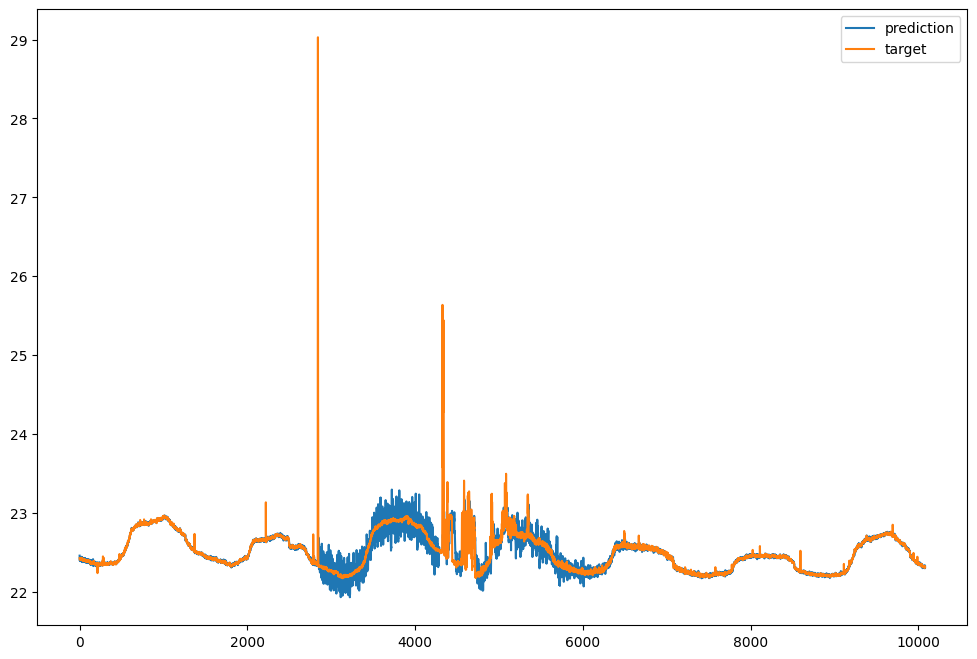

In [33]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [34]:
np.array(pred_list)

array([22.45589828, 22.40681076, 22.39251137, ..., 22.29602432,
       22.3158474 , 22.31793213])

In [35]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [36]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [41]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

0.2124255057424307 %


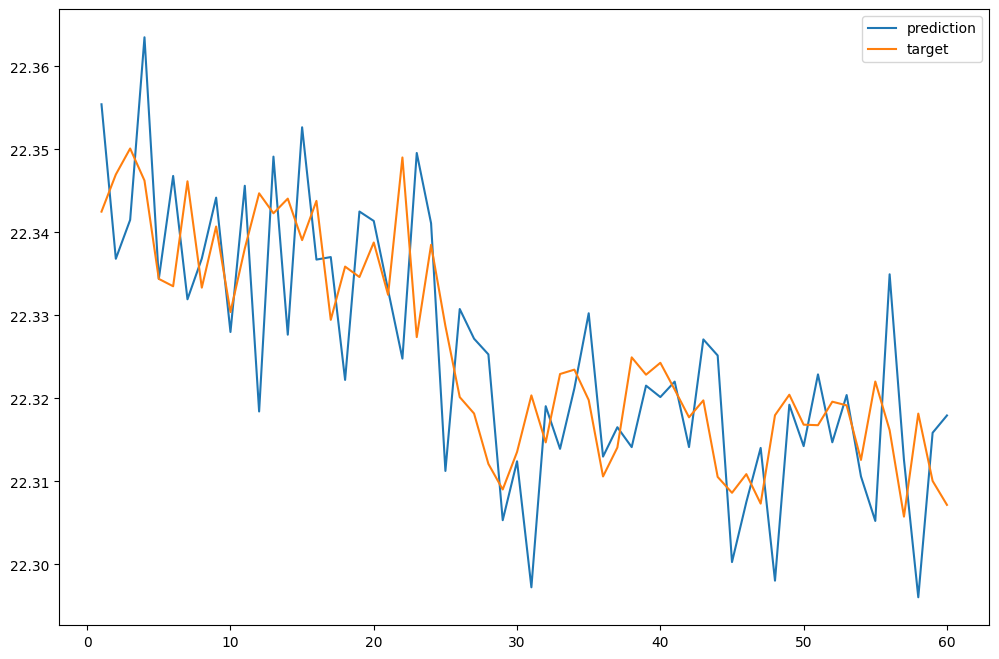

In [38]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [39]:
len(time_list)

10080

In [40]:
np.mean(time_list) 

0.2622477818103064

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다